In [232]:
import numpy as np
import do_mpc
import matplotlib as mpl
import matplotlib.pyplot as plt
import casadi as ca

from carenv import CarEnv

# Customizing Matplotlib:
mpl.rcParams['axes.grid'] = True


In [233]:
T_STEP = 0.1
SETPOINT = np.array([10, 700, 0, 0])
ENV_SIZE = (1200, 800)


## Configure the model

In [234]:
model = do_mpc.model.Model("continuous")

In [235]:
'''
states _x

x_pos
y_pos
theta - heading angle
delta - steering angle
'''
x_pos = model.set_variable(var_type="_x", var_name="x_pos")
y_pos = model.set_variable(var_type="_x", var_name="y_pos")
theta = model.set_variable(var_type="_x", var_name="theta")
delta = model.set_variable(var_type="_x", var_name="delta")

In [236]:
'''
inputs _u

v - velocity
phi - steering rate
'''
v = model.set_variable(var_type="_u", var_name="v")
phi = model.set_variable(var_type="_u", var_name="phi")

In [237]:
'''
time varying parameters _tvp

set_x_pos
set_y_pos
set_theta
set_delta
'''

set_x_pos = model.set_variable(var_type='_tvp', var_name='set_x_pos')
set_y_pos = model.set_variable(var_type='_tvp', var_name='set_y_pos')
set_theta = model.set_variable(var_type='_tvp', var_name='set_theta')
set_delta = model.set_variable(var_type='_tvp', var_name='set_delta')


In [238]:
'''
parameters _p

L - vehicle length
'''
L = 30

In [239]:
'''
rhs (first order differential equasions of _x)
'''
d_x_pos = v * ca.cos(theta)
d_y_pos = v * ca.sin(theta)
d_theta = v * ca.tan(delta) / L
d_delta = phi

model.set_rhs("x_pos", d_x_pos)
model.set_rhs("y_pos", d_y_pos)
model.set_rhs("theta", d_theta)
model.set_rhs("delta", d_delta)

In [240]:
model.setup()

## MPC setup

In [241]:
mpc = do_mpc.controller.MPC(model)
N_HORIZON = 20

mpc.set_param(
    n_horizon = N_HORIZON,
    t_step = T_STEP,
    n_robust = 1,
    store_full_solution = True,
    nlpsol_opts = {'ipopt.print_level':0, 'ipopt.sb': 'yes', 'print_time':0}
)

In [242]:
def norm(x, min, max):
    return (x - min) / (max - min)

In [243]:
POS_GAIN = 22
THETA_GAIN = 1
DELTA_GAIN = 0.5

set_x_pos = model.tvp["set_x_pos"]
set_y_pos = model.tvp["set_y_pos"]
set_theta = model.tvp["set_theta"]
set_delta = model.tvp["set_delta"]

lterm = (
    (norm((x_pos - set_x_pos), 0, ENV_SIZE[0]) * POS_GAIN) ** 2
    + (norm((y_pos - set_y_pos), 0, ENV_SIZE[1]) * POS_GAIN) ** 2
    + ((theta - set_theta) * THETA_GAIN) ** 2
    + ((delta - set_delta) * DELTA_GAIN) ** 2
)

mterm = lterm

mpc.set_objective(mterm=mterm, lterm=lterm)
mpc.set_rterm(v=1e-2, phi=1e-2)

In [244]:
mpc.bounds['lower', '_x', 'x_pos'] = 0
mpc.bounds['upper', '_x', 'y_pos'] = ENV_SIZE[0]

mpc.bounds['lower', '_x', 'y_pos'] = 0
mpc.bounds['upper', '_x', 'y_pos'] = ENV_SIZE[1]

mpc.bounds['lower', '_x', 'delta'] = -ca.pi/4
mpc.bounds['upper', '_x', 'delta'] = ca.pi/4


In [245]:
mpc.bounds['lower', '_u', 'v'] = -120
mpc.bounds['upper', '_u', 'v'] = 120

mpc.bounds['lower', '_u', 'phi'] = -2
mpc.bounds['upper', '_u', 'phi'] = 2

In [246]:
tvp_template = mpc.get_tvp_template()
mpc.set_tvp_fun(lambda t_now: tvp_template)

In [247]:
mpc.setup()

## Simulator

In [248]:
simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(t_step=T_STEP)
simulator.set_tvp_fun(lambda t_now: simulator.get_tvp_template())
simulator.setup()

In [249]:
%%capture

sim_graphics = do_mpc.graphics.Graphics(simulator.data)

fig, ax = plt.subplots(6, sharex=True, figsize=(16,16))
fig.align_ylabels()

for g in [sim_graphics]:
    # _x
    g.add_line(var_type='_x', var_name="x_pos", axis=ax[0])
    g.add_line(var_type='_x', var_name="y_pos", axis=ax[1])    
    g.add_line(var_type='_x', var_name="theta", axis=ax[2])
    g.add_line(var_type='_x', var_name="delta", axis=ax[3])

    # _u
    g.add_line(var_type='_u', var_name="v", axis=ax[4])
    g.add_line(var_type='_u', var_name="phi", axis=ax[5])


ax[0].set_ylabel('x_pos')
ax[1].set_ylabel('y_pos')
ax[2].set_ylabel('theta')
ax[3].set_ylabel('delta')
ax[4].set_ylabel('v')
ax[5].set_ylabel('phi')

ax[0].set_xlabel('time [s]')
ax[1].set_xlabel('time [s]')
ax[2].set_xlabel('time [s]')
ax[3].set_xlabel('time [s]')
ax[4].set_xlabel('time [s]')
ax[5].set_xlabel('time [s]')

In [250]:
SIM_TIME = 10

#### Test on random positions

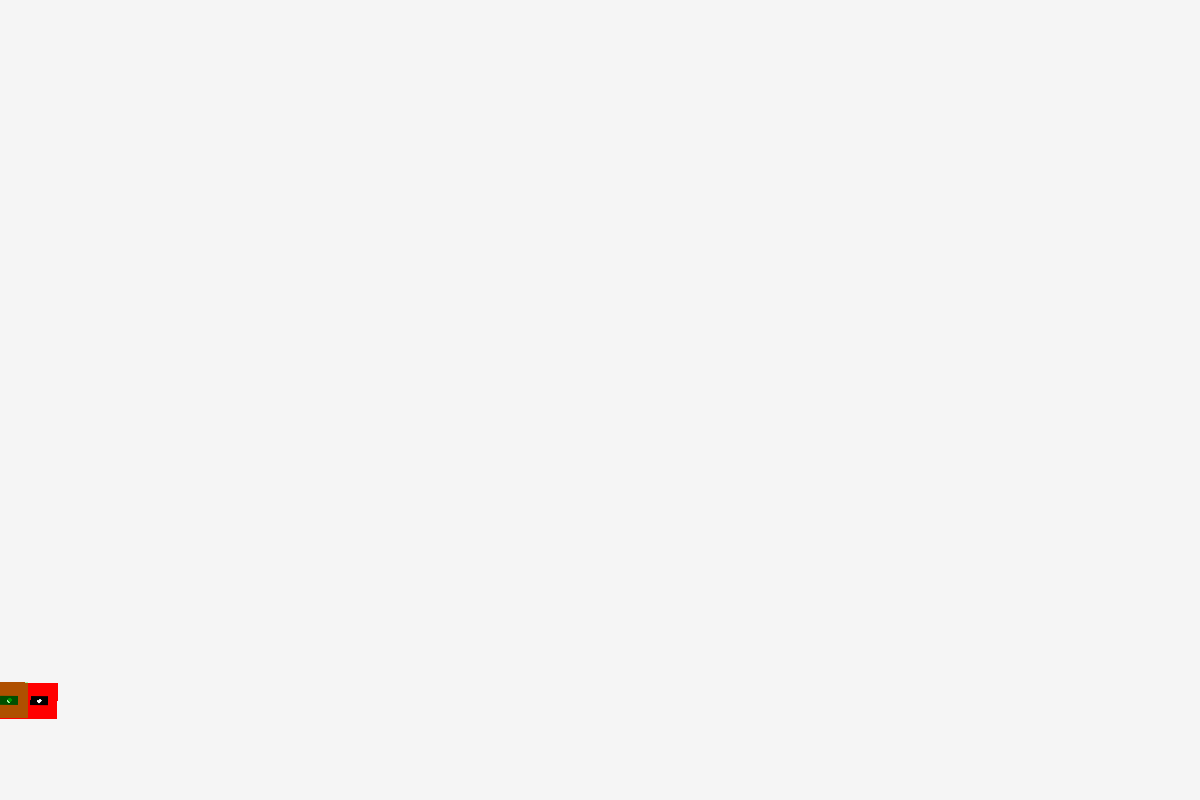

Simulation 5/5


In [210]:
N = 5

for n in range(N):

    rand_x_pos = np.random.randint(ENV_SIZE[0] // 7, ENV_SIZE[0])
    rand_y_pos = np.random.randint(0, ENV_SIZE[1])
    rand_theta = np.random.uniform(-np.pi, np.pi)
    rand_delta = np.random.uniform(-np.pi / 4, np.pi / 4)

    x0 = np.array([rand_x_pos, rand_y_pos, rand_theta, rand_delta]).reshape(-1, 1)

    simulator.x0 = x0
    mpc.x0 = x0
    mpc.set_initial_guess()

    with CarEnv(
        L=L, setpoint=SETPOINT, env_size=ENV_SIZE, t_step=T_STEP, notebook=True
    ) as env:
        for _ in range(int(SIM_TIME * 1 / T_STEP)):
            
            tvp_template["_tvp", 0:N_HORIZON+1, "set_x_pos"] = SETPOINT[0]
            tvp_template["_tvp", 0:N_HORIZON+1, "set_y_pos"] = SETPOINT[1]
            tvp_template["_tvp", 0:N_HORIZON+1, "set_theta"] = SETPOINT[2]
            tvp_template["_tvp", 0:N_HORIZON+1, "set_delta"] = SETPOINT[3]

            u0 = mpc.make_step(x0)
            x0 = simulator.make_step(u0)
            env.make_step(x0)

            print(f"Simulation {n+1}/{N}")

#### Test on a specific position

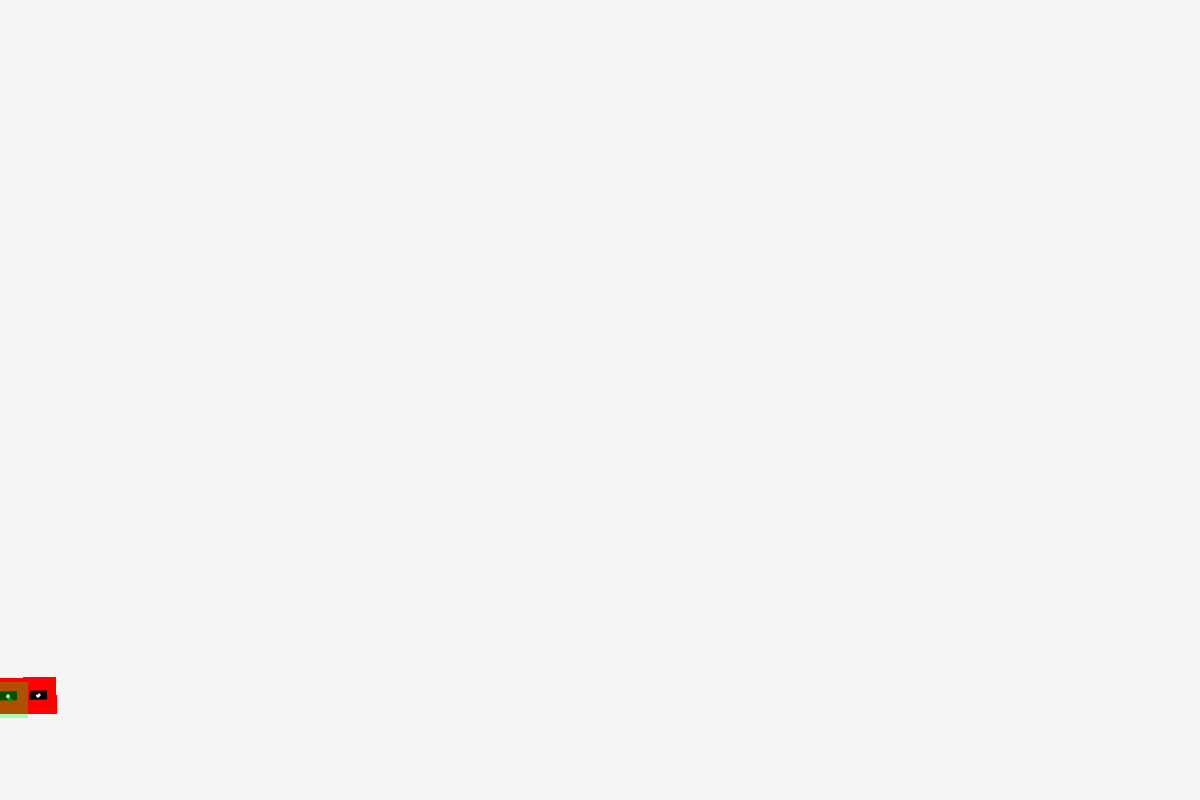

In [251]:
x0 = np.array([5, 100, 0, 0]).reshape(-1,1)

simulator.x0 = x0
mpc.x0 = x0

mpc.set_initial_guess()

with CarEnv(
        L=L, setpoint=SETPOINT, env_size=ENV_SIZE, t_step=T_STEP, notebook=True
    ) as env:
        for _ in range(int(SIM_TIME * 1 / T_STEP)):
            
            tvp_template["_tvp", 0:N_HORIZON+1, "set_x_pos"] = SETPOINT[0]
            tvp_template["_tvp", 0:N_HORIZON+1, "set_y_pos"] = SETPOINT[1]
            tvp_template["_tvp", 0:N_HORIZON+1, "set_theta"] = SETPOINT[2]
            tvp_template["_tvp", 0:N_HORIZON+1, "set_delta"] = SETPOINT[3]

            u0 = mpc.make_step(x0)
            x0 = simulator.make_step(u0)
            env.make_step(x0)

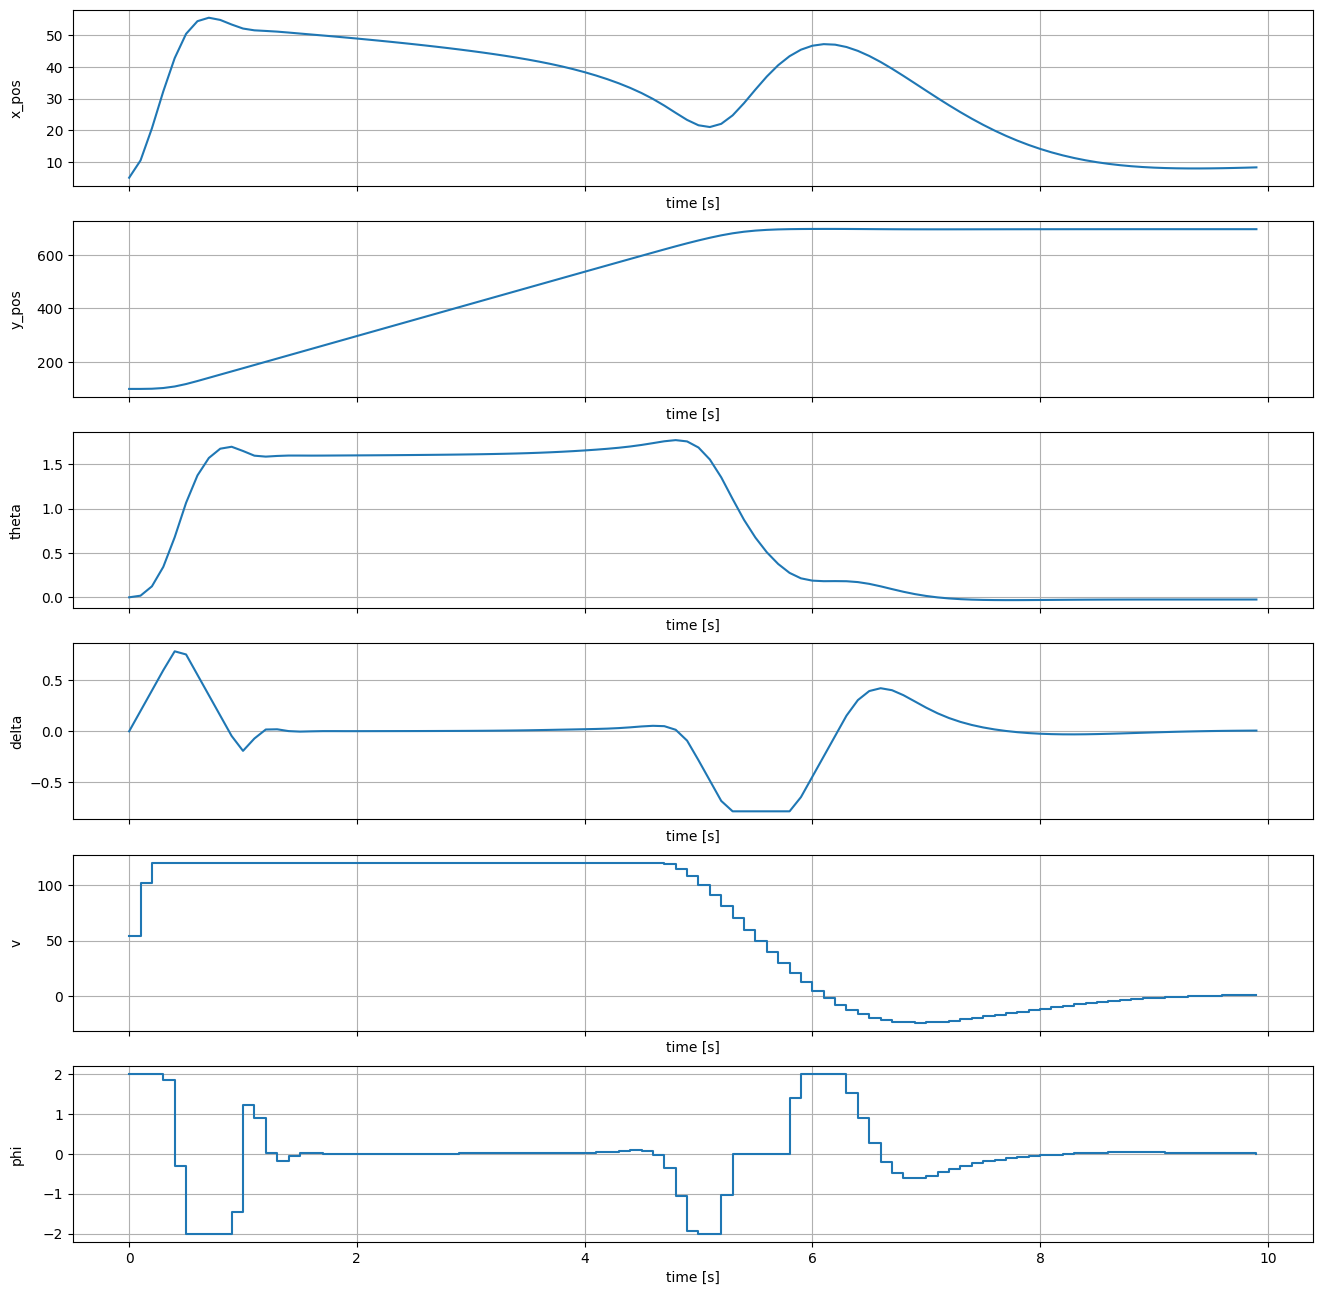

In [252]:
sim_graphics.plot_results()
sim_graphics.reset_axes()
fig